# GoEmotions – DistilBERT (Pretrained Transformer) on GPU

This notebook trains a **DistilBERT** classifier on a 3-class GoEmotions Reddit dataset
(`Positive`, `Negative`, `Neutral`) using both unbalanced and balanced versions of the data.

It mirrors your TF-IDF / FastText notebooks by providing:
- Same label setup
- Train/Test splits
- Accuracy, macro Precision, macro Recall, macro F1
- Confusion matrices for **unbalanced** and **balanced** experiments

GPU is used automatically if available (e.g., GTX 3050); otherwise training falls back to CPU.

In [1]:
import sys
print(sys.executable)

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install pandas numpy matplotlib scikit-learn tqdm regex seaborn
!{sys.executable} -m pip install ipykernel notebook jupyter
!{sys.executable} -m pip install transformers datasets sentencepiece

try:
    !{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
except:
    !{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

c:\Users\Abhay\AppData\Local\Programs\Python\Python310\python.exe


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import sys
print('Python executable:', sys.executable)



import numpy as np
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

print('Torch version:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU device:', torch.cuda.get_device_name(0))
else:
    print('Running on CPU')

Python executable: c:\Users\Abhay\AppData\Local\Programs\Python\Python310\python.exe
Torch version: 2.5.1+cu121
CUDA available: True
GPU device: NVIDIA GeForce RTX 3050 Laptop GPU


## 1. Load GoEmotions data and map to 3 classes

In [ ]:

df1 = pd.read_csv('goemotions_1.csv')
df2 = pd.read_csv('goemotions_2.csv')
df3 = pd.read_csv('goemotions_3.csv')

df = pd.concat([df1, df2, df3], axis=0)
print('Shape (raw):', df.shape)
df.head()

Shape (raw): (211225, 37)


,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:

positive = [
    'admiration','amusement','approval','caring','curiosity','desire',
    'excitement','gratitude','joy','love','optimism','pride','relief'
]
negative = [
    'anger','annoyance','confusion','disappointment','disapproval','disgust',
    'embarrassment','fear','grief','nervousness','remorse','sadness'
]
neutral = ['realization','surprise','neutral']

def Emotion_Labels(row):
    if row[positive].sum() > 0:
        return 'Positive'
    elif row[negative].sum() > 0:
        return 'Negative'
    elif row[neutral].sum() > 0:
        return 'Neutral'
    else:
        return pd.NA

df['Emotions'] = df.apply(Emotion_Labels, axis=1)
df.dropna(subset=['Emotions'], inplace=True)
print('Shape after label mapping:', df.shape)
df['Emotions'].value_counts()

Shape after label mapping: (207814, 38)


Emotions
Positive    90895
Neutral     63706
Negative    53213
Name: count, dtype: int64

## 2. Build text field and clean (regex only)

In [5]:
def clean(text: str) -> str:
    if pd.isna(text):
        return ''
    text = text.lower()
    # remove Reddit-style subreddit refs like r/whatever
    text = re.sub(r'\br/\w+', ' ', text)
    text = text.replace('\n', ' ')
    # remove brackets and quotes
    text = re.sub(r'[{}\[\]()\|:\"\']', ' ', text)
    text = re.sub(r'[“”‘’]', ' ', text)
    # remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    # remove emails
    text = re.sub(r'\S+@\S+', ' ', text)
    # remove user handles (u/username or @username)
    text = re.sub(r'u/\w+|@\w+', ' ', text)
    # keep only alphanumerics and space
    text = re.sub(r'[^a-z0-9 ]', ' ', text)
    # collapse multiple spaces
    text = re.sub(r'\s{2,}', ' ', text)
    return text.strip()

# Unbalanced dataframe (original distribution)
dff_unbal = pd.DataFrame()
dff_unbal['Text'] = (
    df['text'].astype(str)
    + ' | Author: ' + df['author'].astype(str)
    + ' | Subreddit: ' + df['subreddit'].astype(str)
)
dff_unbal['Emotions'] = df['Emotions']

dff_unbal['Text'] = dff_unbal['Text'].apply(clean)
dff_unbal.head()

,Text,Emotions
0,that game hurt author brdd9 subreddit nrl,Negative
2,you do right if you don t care then fuck em au...,Neutral
3,man i love reddit author mrsrobertshaw subredd...,Positive
4,name was nowhere near them he was by the falco...,Neutral
5,right considering it s such an important docum...,Positive


## 3. Create balanced dataset by oversampling minority classes

In [6]:
classes = ['Positive', 'Neutral', 'Negative']
counts = df['Emotions'].value_counts()
print('Original class counts:')
print(counts)

# Use minimum class count as target to avoid exploding dataset size
target_per_class = counts.min()
print('\nTarget per class (balanced):', target_per_class)

balanced_frames = []
for cls in classes:
    cls_df = df[df['Emotions'] == cls]
    if len(cls_df) >= target_per_class:
        cls_bal = cls_df.sample(n=target_per_class, random_state=42)
    else:
        cls_bal = cls_df.sample(n=target_per_class, replace=True, random_state=42)
    balanced_frames.append(cls_bal)

bdf = pd.concat(balanced_frames).sample(frac=1, random_state=42).reset_index(drop=True)

dff_bal = pd.DataFrame()
dff_bal['Text'] = (
    bdf['text'].astype(str)
    + ' | Author: ' + bdf['author'].astype(str)
    + ' | Subreddit: ' + bdf['subreddit'].astype(str)
)
dff_bal['Emotions'] = bdf['Emotions']

dff_bal['Text'] = dff_bal['Text'].apply(clean)
print('Balanced class counts:')
dff_bal['Emotions'].value_counts()

Original class counts:
Emotions
Positive    90895
Neutral     63706
Negative    53213
Name: count, dtype: int64

Target per class (balanced): 53213
Balanced class counts:


Emotions
Positive    53213
Neutral     53213
Negative    53213
Name: count, dtype: int64

## 4. Train-test split for unbalanced and balanced data

In [7]:
# Unbalanced
x_unbal = dff_unbal['Text']
y_unbal = dff_unbal['Emotions']

x_train_unbal, x_test_unbal, y_train_unbal, y_test_unbal = train_test_split(
    x_unbal, y_unbal,
    test_size=0.2,
    stratify=y_unbal,
    random_state=42
)

# Balanced
x_bal = dff_bal['Text']
y_bal = dff_bal['Emotions']

x_train_bal, x_test_bal, y_train_bal, y_test_bal = train_test_split(
    x_bal, y_bal,
    test_size=0.2,
    stratify=y_bal,
    random_state=42
)

print('Unbalanced train size:', len(x_train_unbal), 'test size:', len(x_test_unbal))
print('Balanced   train size:', len(x_train_bal), 'test size:', len(x_test_bal))

Unbalanced train size: 166251 test size: 41563
Balanced   train size: 127711 test size: 31928


## 5. Helper function to train DistilBERT (uses GPU if available)

In [8]:
def train_distilbert(x_train, x_test, y_train, y_test, exp_name='unbalanced'):
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    num_labels = len(le.classes_)
    label2id = {label: i for i, label in enumerate(le.classes_)}
    id2label = {i: label for label, i in label2id.items()}

    model_name = 'distilbert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        label2id=label2id,
        id2label=id2label
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print('using device:', device)

    max_length = 128

    def tokenize_batch(texts):
        return tokenizer(
            list(texts),
            padding=True,
            truncation=True,
            max_length=max_length
        )

    train_encodings = tokenize_batch(x_train)
    test_encodings = tokenize_batch(x_test)

    class GoEmotionsDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels
        def __len__(self):
            return len(self.labels)
        def __getitem__(self, idx):
            item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

    train_dataset = GoEmotionsDataset(train_encodings, y_train_enc)
    test_dataset = GoEmotionsDataset(test_encodings, y_test_enc)

    batch_size = 8

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(axis=-1)
        acc = accuracy_score(labels, preds)
        prec = precision_score(labels, preds, average='macro', zero_division=0)
        rec = recall_score(labels, preds, average='macro', zero_division=0)
        f1 = f1_score(labels, preds, average='macro', zero_division=0)
        return {
            'accuracy': acc,
            'precision_macro': prec,
            'recall_macro': rec,
            'f1': f1
        }

    training_args = TrainingArguments(
        output_dir=f'./results-distilbert-{exp_name}',
        num_train_epochs=2,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        evaluation_strategy='no',
        save_strategy='no',
        logging_steps=200,
        report_to='none'
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()

    pred_output = trainer.predict(test_dataset)
    logits = pred_output.predictions
    pred_ids = np.argmax(logits, axis=-1)
    y_pred = le.inverse_transform(pred_ids)

    return y_pred, y_test.reset_index(drop=True), le


## 6. Train DistilBERT on unbalanced and balanced data

In [9]:
print('Training on UNBALANCED data...')
pred_unbal, y_test_unbal_series, le_unbal = train_distilbert(
    x_train_unbal, x_test_unbal, y_train_unbal, y_test_unbal,
    exp_name='unbalanced'
)

print('\nTraining on BALANCED data...')
pred_bal, y_test_bal_series, le_bal = train_distilbert(
    x_train_bal, x_test_bal, y_train_bal, y_test_bal,
    exp_name='balanced'
)

Training on UNBALANCED data...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


using device: cuda


  0%|          | 0/41564 [00:00<?, ?it/s]

{'loss': 0.9765, 'grad_norm': 6.55896520614624, 'learning_rate': 4.975940717928977e-05, 'epoch': 0.01}
{'loss': 0.9143, 'grad_norm': 4.044864654541016, 'learning_rate': 4.951881435857954e-05, 'epoch': 0.02}
{'loss': 0.8942, 'grad_norm': 2.841451644897461, 'learning_rate': 4.927822153786931e-05, 'epoch': 0.03}
{'loss': 0.8751, 'grad_norm': 3.206944227218628, 'learning_rate': 4.903762871715908e-05, 'epoch': 0.04}
{'loss': 0.8931, 'grad_norm': 4.61749792098999, 'learning_rate': 4.879703589644885e-05, 'epoch': 0.05}
{'loss': 0.8528, 'grad_norm': 2.8644864559173584, 'learning_rate': 4.855644307573862e-05, 'epoch': 0.06}
{'loss': 0.8493, 'grad_norm': 4.490121364593506, 'learning_rate': 4.831585025502839e-05, 'epoch': 0.07}
{'loss': 0.8779, 'grad_norm': 7.289890289306641, 'learning_rate': 4.807525743431816e-05, 'epoch': 0.08}
{'loss': 0.8671, 'grad_norm': 6.311508655548096, 'learning_rate': 4.783466461360793e-05, 'epoch': 0.09}
{'loss': 0.8535, 'grad_norm': 3.6323368549346924, 'learning_rate'

  0%|          | 0/5196 [00:00<?, ?it/s]


Training on BALANCED data...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


using device: cuda


  0%|          | 0/31928 [00:00<?, ?it/s]

{'loss': 1.0344, 'grad_norm': 11.372203826904297, 'learning_rate': 4.968679528940115e-05, 'epoch': 0.01}
{'loss': 0.9559, 'grad_norm': 7.284401893615723, 'learning_rate': 4.937359057880231e-05, 'epoch': 0.03}
{'loss': 0.9181, 'grad_norm': 4.387868881225586, 'learning_rate': 4.906038586820346e-05, 'epoch': 0.04}
{'loss': 0.8994, 'grad_norm': 5.292949676513672, 'learning_rate': 4.874718115760461e-05, 'epoch': 0.05}
{'loss': 0.9076, 'grad_norm': 5.559356689453125, 'learning_rate': 4.8433976447005766e-05, 'epoch': 0.06}
{'loss': 0.9095, 'grad_norm': 5.005042552947998, 'learning_rate': 4.8120771736406916e-05, 'epoch': 0.08}
{'loss': 0.8763, 'grad_norm': 5.472587585449219, 'learning_rate': 4.780756702580807e-05, 'epoch': 0.09}
{'loss': 0.8691, 'grad_norm': 9.443540573120117, 'learning_rate': 4.749436231520922e-05, 'epoch': 0.1}
{'loss': 0.8606, 'grad_norm': 5.876282215118408, 'learning_rate': 4.7181157604610373e-05, 'epoch': 0.11}
{'loss': 0.8749, 'grad_norm': 4.407032012939453, 'learning_ra

  0%|          | 0/3991 [00:00<?, ?it/s]

## 7. Metrics and confusion matrices

In [10]:
# Metrics for UNBALANCED
print('=== DistilBERT (UNBALANCED) ===')
print('Accuracy :', accuracy_score(y_test_unbal_series, pred_unbal))
print('Precision (macro):', precision_score(y_test_unbal_series, pred_unbal, average='macro'))
print('Recall (macro):   ', recall_score(y_test_unbal_series, pred_unbal, average='macro'))
print('F1 (macro):       ', f1_score(y_test_unbal_series, pred_unbal, average='macro'))

# Metrics for BALANCED
print('\n=== DistilBERT (BALANCED) ===')
print('Accuracy :', accuracy_score(y_test_bal_series, pred_bal))
print('Precision (macro):', precision_score(y_test_bal_series, pred_bal, average='macro'))
print('Recall (macro):   ', recall_score(y_test_bal_series, pred_bal, average='macro'))
print('F1 (macro):       ', f1_score(y_test_bal_series, pred_bal, average='macro'))

=== DistilBERT (UNBALANCED) ===
Accuracy : 0.6493275268868945
Precision (macro): 0.6322323397417026
Recall (macro):    0.631739257525167
F1 (macro):        0.631187288174495

=== DistilBERT (BALANCED) ===
Accuracy : 0.6417251315459784
Precision (macro): 0.6402852745328661
Recall (macro):    0.6417270643992344
F1 (macro):        0.6400890344652336


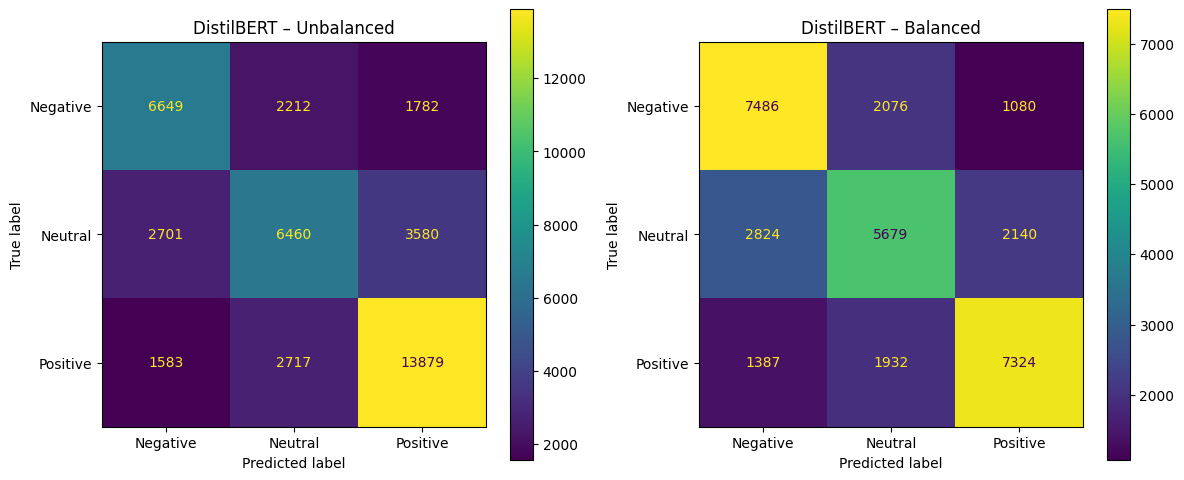

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

labels_unbal = le_unbal.classes_
cm_unbal = confusion_matrix(y_test_unbal_series, pred_unbal, labels=labels_unbal)
disp_unbal = ConfusionMatrixDisplay(confusion_matrix=cm_unbal, display_labels=labels_unbal)
disp_unbal.plot(ax=axes[0], values_format='d')
axes[0].set_title('DistilBERT – Unbalanced')

labels_bal = le_bal.classes_
cm_bal = confusion_matrix(y_test_bal_series, pred_bal, labels=labels_bal)
disp_bal = ConfusionMatrixDisplay(confusion_matrix=cm_bal, display_labels=labels_bal)
disp_bal.plot(ax=axes[1], values_format='d')
axes[1].set_title('DistilBERT – Balanced')

plt.tight_layout()
plt.show()

## 8. Combined metrics table

In [12]:
metrics = {
    'DistilBERT (Unbalanced)': {
        'Accuracy': accuracy_score(y_test_unbal_series, pred_unbal),
        'Precision': precision_score(y_test_unbal_series, pred_unbal, average='macro'),
        'Recall': recall_score(y_test_unbal_series, pred_unbal, average='macro'),
        'F1': f1_score(y_test_unbal_series, pred_unbal, average='macro')
    },
    'DistilBERT (Balanced)': {
        'Accuracy': accuracy_score(y_test_bal_series, pred_bal),
        'Precision': precision_score(y_test_bal_series, pred_bal, average='macro'),
        'Recall': recall_score(y_test_bal_series, pred_bal, average='macro'),
        'F1': f1_score(y_test_bal_series, pred_bal, average='macro')
    }
}

metrics_df = pd.DataFrame(metrics).T
metrics_df

,Accuracy,Precision,Recall,F1
DistilBERT (Unbalanced),0.649328,0.632232,0.631739,0.631187
DistilBERT (Balanced),0.641725,0.640285,0.641727,0.640089
